<a href="https://www.kaggle.com/code/yasinsoylu123/brain-tumor-classification?scriptVersionId=124242571" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tqdm import tqdm
import os
from sklearn.utils import shuffle

import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings


In [2]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']


In [3]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 92.27it/s] 


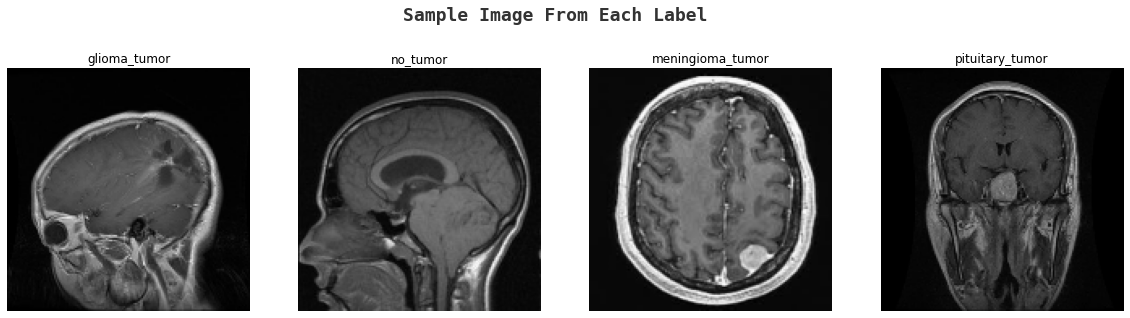

In [4]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [5]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train.shape

(3264, 150, 150, 3)

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [7]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)




In [8]:
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same',input_shape=(image_size,image_size,3))) 
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3))) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(BatchNormalization())
model.add(Dropout(0.35))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization()) 

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(BatchNormalization())
model.add(Dropout(0.35)) #64 --> 42

model.add(Conv2D(64, (3, 3), padding='same')) 
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Flatten()) 
model.add(Dropout(0.5)) 
model.add(Dense(512)) 
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dense(4)) 
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 150, 150, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 148, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 74, 74, 64)        2

In [9]:
batch_size=32
epochs = 50

In [10]:
model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [11]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("cnn.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [12]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =20, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
83/83 [==============================] - 14s 70ms/step - loss: 1.1352 - accuracy: 0.6731 - val_loss: 12.3347 - val_accuracy: 0.1735

Epoch 00001: val_accuracy improved from -inf to 0.17347, saving model to cnn.h5
Epoch 2/20
83/83 [==============================] - 4s 54ms/step - loss: 0.4940 - accuracy: 0.8176 - val_loss: 0.8390 - val_accuracy: 0.7109

Epoch 00002: val_accuracy improved from 0.17347 to 0.71088, saving model to cnn.h5
Epoch 3/20
83/83 [==============================] - 4s 53ms/step - loss: 0.3509 - accuracy: 0.8740 - val_loss: 0.5482 - val_accuracy: 0.7993

Epoch 00003: val_accuracy improved from 0.71088 to 0.79932, saving model to cnn.h5
Epoch 4/20
83/83 [==============================] - 4s 54ms/step - loss: 0.2072 - accuracy: 0.9262 - val_loss: 0.5727 - val_accuracy: 0.8163

Epoch 00004: val_accuracy improved from 0.79932 to 0.81633, saving model to cnn.h5
Epoch 5/20
83/83 [==============================] - 4s 54ms/step - loss: 0.1475 - accuracy: 0.9501 - 

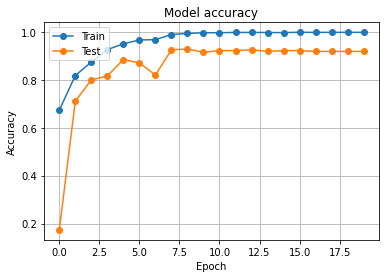

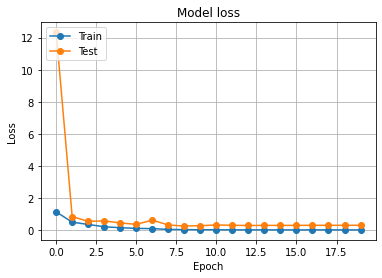

In [13]:
plt.plot(history.history['accuracy'],marker='o')
plt.plot(history.history['val_accuracy'],marker='o')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()

# Plot loss values vs epoch
plt.plot(history.history['loss'],marker='o')
plt.plot(history.history['val_loss'],marker='o')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()

# EfficientNetB0

In [14]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16719872/16705208 [==============================] - 1s 0us/step


In [15]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [16]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [17]:
earlystop = EarlyStopping(monitor='val_loss', patience=5)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [18]:
history = model.fit(X_train, y_train, batch_size = 64, validation_data = (X_test, y_test),
                     epochs = 20, callbacks =[callbacks] )

Epoch 1/20
46/46 [==============================] - 19s 254ms/step - loss: 0.4363 - accuracy: 0.8281 - val_loss: 1.2923 - val_accuracy: 0.7370
Epoch 2/20
46/46 [==============================] - 10s 211ms/step - loss: 0.1229 - accuracy: 0.9544 - val_loss: 1.0015 - val_accuracy: 0.7890
Epoch 3/20
46/46 [==============================] - 10s 210ms/step - loss: 0.0734 - accuracy: 0.9775 - val_loss: 0.2466 - val_accuracy: 0.9205
Epoch 4/20
46/46 [==============================] - 10s 208ms/step - loss: 0.0626 - accuracy: 0.9816 - val_loss: 0.1589 - val_accuracy: 0.9511
Epoch 5/20
46/46 [==============================] - 10s 211ms/step - loss: 0.0446 - accuracy: 0.9840 - val_loss: 0.3605 - val_accuracy: 0.9358
Epoch 6/20
46/46 [==============================] - 10s 210ms/step - loss: 0.0754 - accuracy: 0.9707 - val_loss: 0.4636 - val_accuracy: 0.9021
Epoch 7/20
46/46 [==============================] - 10s 212ms/step - loss: 0.0705 - accuracy: 0.9775 - val_loss: 1.0675 - val_accuracy: 0.7890

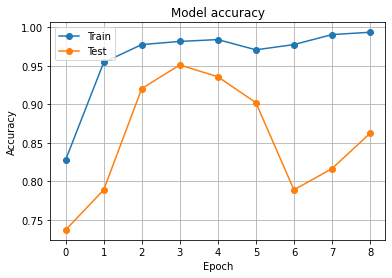

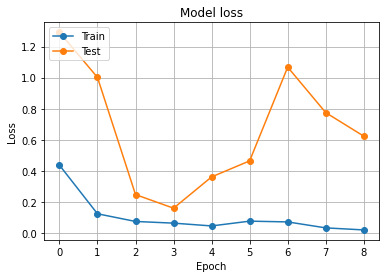

In [19]:
plt.plot(history.history['accuracy'],marker='o')
plt.plot(history.history['val_accuracy'],marker='o')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()

plt.show()

# Plot loss values vs epoch
plt.plot(history.history['loss'],marker='o')
plt.plot(history.history['val_loss'],marker='o')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()

plt.show()

# vgg16

In [20]:
vgg_model=VGG16(input_shape=(image_size,image_size,3) , weights='imagenet' , include_top=False,pooling="max")


58900480/58889256 [==============================] - 2s 0us/step


In [21]:
for layer in vgg_model.layers:
    layer.trainable  = False

In [22]:
model = Sequential()
model.add(vgg_model)

model.add(Flatten()) 
model.add(Activation('relu'))
Dropout(rate=0.5)
model.add(Dense(4)) 
model.add(Activation('softmax'))



model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
activation_7 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 2052      
_________________________________________________________________
activation_8 (Activation)    (None, 4)                 0         
Total params: 14,716,740
Trainable params: 2,052
Non-trainable params: 14,714,688
_________________________________________________________________


In [23]:
model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [24]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [25]:
history = model.fit(X_train, y_train, batch_size = batch_size, validation_data = (X_test, y_test),
                    steps_per_epoch = len(X_train) / batch_size, epochs = 20, callbacks =[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
91/91 [==============================] - 9s 74ms/step - loss: 11.2064 - accuracy: 0.4631 - val_loss: 4.9006 - val_accuracy: 0.6728

Epoch 00001: val_accuracy improved from -inf to 0.67278, saving model to effnet.h5
Epoch 2/20
91/91 [==============================] - 3s 37ms/step - loss: 4.2983 - accuracy: 0.6697 - val_loss: 3.8228 - val_accuracy: 0.7309

Epoch 00002: val_accuracy improved from 0.67278 to 0.73089, saving model to effnet.h5
Epoch 3/20
91/91 [==============================] - 3s 36ms/step - loss: 2.9220 - accuracy: 0.7365 - val_loss: 3.1588 - val_accuracy: 0.7339

Epoch 00003: val_accuracy improved from 0.73089 to 0.73394, saving model to effnet.h5
Epoch 4/20
91/91 [==============================] - 3s 36ms/step - loss: 2.2269 - accuracy: 0.7726 - val_loss: 2.5021 - val_accuracy: 0.7492

Epoch 00004: val_accuracy improved from 0.73394 to 0.74924, saving model to effnet.h5
Epoch 5/20
91/91 [==============================] - 3s 36ms/step - loss: 1.7324 - accuracy

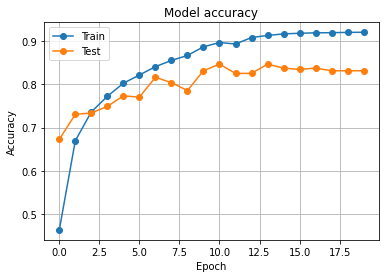

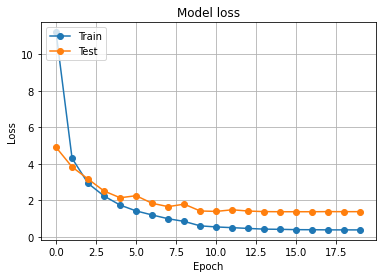

In [26]:
plt.plot(history.history['accuracy'],marker='o')
plt.plot(history.history['val_accuracy'],marker='o')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()

plt.show()

# Plot loss values vs epoch
plt.plot(history.history['loss'],marker='o')
plt.plot(history.history['val_loss'],marker='o')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()

plt.show()

In [27]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_test_new,pred))


              precision    recall  f1-score   support

           0       0.80      0.84      0.82        93
           1       0.81      0.82      0.82        51
           2       0.78      0.74      0.76        96
           3       0.94      0.93      0.94        87

    accuracy                           0.83       327
   macro avg       0.83      0.83      0.83       327
weighted avg       0.83      0.83      0.83       327



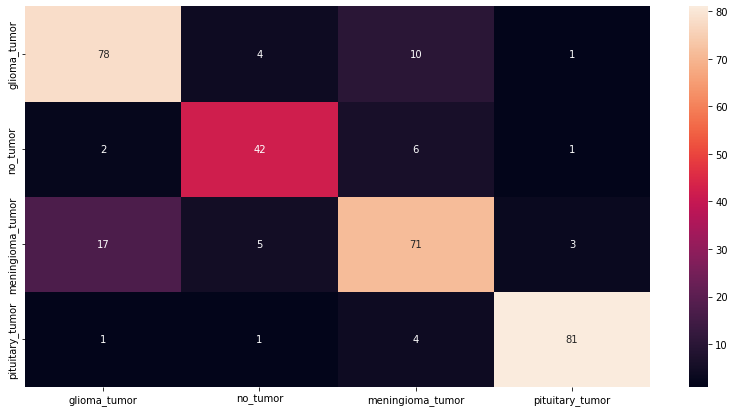

In [29]:
from sklearn.metrics import confusion_matrix

fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)


plt.show()

In [30]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [31]:
import ipywidgets as widgets

uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [32]:
from IPython.display import display,clear_output

button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])